In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

from sys import path
path.append('/home/alex/anaconda3/lib/python3.9/site-packages')
import plotly.express as px

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(120, 'm').delta

In [2]:
class BaseSpreadEncoder:
    def __init__(self, tick_size):
        self.tick_size = tick_size
        
        self.thresholds = None
        self.codes      = None
    
    
    def fit(self, spread):
        assert False, "not implemented yet"

        
    def predict(self, spread):
        #clip to be sure spread >= tick_size
        spread = np.clip(spread, self.tick_size, np.inf)
        #to int
        spread = (spread / self.tick_size).astype(int)
        #previous threshold
        prv = 0
        for thr, code in zip(self.thresholds, self.codes):
            idx = (prv < spread) & (spread <= thr) 
            spread[idx] = code
            prv = thr
        assert set(spread).issubset(self.spread_set)
        return spread

In [3]:
class SpreadEncoder(BaseSpreadEncoder):
    def __init__(self, tick_size, max_quantile=0.99, max_steps=5, step_inc=4):
        super().__init__(tick_size)
        self.tick_size    = tick_size
        self.max_quantile = max_quantile
        self.max_steps    = max_steps
        self.step_inc     = step_inc
    
    
    def fit(self, spread):
        #clip to be sure spread >= tick_size
        spread = np.clip(spread, self.tick_size, np.inf)
        #to int
        spread = (spread / self.tick_size).astype(int)
        #max spread to consider
        max_spread = np.quantile(spread, self.max_quantile)
        #build array of thresholds and codes
        self.thresholds = [1]
        self.codes = [1]
        step = 1
        n_steps = 1
        while self.thresholds[-1] < max_spread:
            self.codes.append(self.thresholds[-1] + (step+1) // 2)
            self.thresholds.append(self.thresholds[-1] + step)
            
            n_steps += 1
            if n_steps == self.max_steps:
                step += self.step_inc
                n_steps = 0    
        self.thresholds[-1] = np.inf
        #for example, if step_inc = 2, max_step = 4
        #thresholds = [1, 2, 3, 4, 7, 10, 13, 16, 21, 26, 31, 36, ..., np.inf]
        self.m_spread = len(self.codes)
        self.spread_set = self.codes

In [4]:
class DummySpreadEncoder(BaseSpreadEncoder):
    def __init__(self, tick_size, max_quantile=0.99, n_bins=20):
        super().__init__(tick_size)
        self.tick_size    = tick_size
        self.max_quantile = max_quantile
        self.n_bins = n_bins
    
    
    def fit(self, spread):
        #clip to be sure spread >= tick_size
        spread = np.clip(spread, self.tick_size, np.inf)
        #to int
        spread = (spread / self.tick_size).astype(int)
        #max spread to consider
        max_spread = np.quantile(spread, self.max_quantile)
        #build array of thresholds and codes
        n_bins = min(self.n_bins, max_spread)
        self.thresholds = [i for i in range(1, n_bins + 1)]
        self.codes = [i for i in range(1, n_bins + 1)]
        thresholds[-1] = np.inf
        self.m_spread = len(self.codes)

In [5]:
class UniformSpreadEncoder(BaseSpreadEncoder):
    def __init__(self, tick_size, max_quantile=0.999, n_bins1=10, n_bins2=10):
        super().__init__(tick_size)
        self.tick_size    = tick_size
        self.max_quantile = max_quantile
        self.n_bins1 = n_bins1
        self.n_bins2 = n_bins2
    
    
    def fit(self, spread):
        #clip to be sure spread >= tick_size
        spread = np.clip(spread, self.tick_size, np.inf)
        #to int
        spread = (spread / self.tick_size).astype(int)
        #max spread to consider
        max_spread = np.quantile(spread, self.max_quantile)
        spread = np.clip(spread, 1, max_spread)
        #build array of thresholds and codes
        self.thresholds = [i for i in range(1, self.n_bins1)]
        self.codes = [i for i in range(1, self.n_bins1)]
        
        counter = sorted(Counter(spread).items())
        
        total = len(spread) 
        
        current = sum( cont for _, cont in counter[:self.n_bins1]  )
        
        dcount = (total - current) / (self.n_bins2)
        
        cnts = 0
        vals = []
        for val, cnt in counter[self.n_bins1:]:
            
            cnts += cnt
            vals.append(val)
            
            if cnts >= dcount:
                self.thresholds.append(val)
                self.codes.append(int(np.median(vals)))
                
                cnts = 0
                vals = []
        self.thresholds[-1] = np.inf
        self.spread_set = self.codes
        self.m_spread = len(self.codes)

In [6]:
class Encoder:
    def __init__(self, n_imb, spread_encoder):
        self.n_imb = n_imb
        self.spread_encoder = spread_encoder
    
    
    def fit(self, imb, spread, dm):
        self.imb_set = list(range(0, self.n_imb))
        #fit spread encoder
        self.spread_encoder.fit(spread)
        self.spread_set = self.spread_encoder.spread_set
        self.m_spread = len(self.spread_set)

        #fit dm encoder
        q = np.quantile(np.abs(dm[dm != 0]), 0.99)
        self.q1, self.q2 = -q, q
        dm = np.clip(dm, self.q1, self.q2)
        dm = np.round_(dm, 2)
        self.dm_set = sorted(set(dm) | set(-dm))
        self.k_dm = len(self.dm_set)
    
    
    def predict(self, imb, spread, dm=None):
        #round imbalance
        imb = (imb * self.n_imb).astype(int)
        assert set(imb).issubset(self.imb_set)
        
        spread = self.spread_encoder.predict(spread)
        
        if dm is None:
            return imb, spread
        #round dm
        dm = np.clip(dm, self.q1, self.q2)
        dm = np.round_(dm, 2)
        assert set(dm).issubset(self.dm_set)
        
        return imb, spread, dm

In [7]:
class SimpleMicroPrice:
    def __init__(self, encoder:Encoder):
        self.encoder = encoder
    
    
    def fit(self, I, S, dM):
        self.encoder.fit(I, S, dM)
        I, S, dM = self.encoder.predict(I, S, dM)
        
        self.imb_set    = self.encoder.imb_set
        self.spread_set = self.encoder.spread_set
        self.dm_set     = self.encoder.dm_set
        
        n, m, k = self.encoder.n_imb, self.encoder.m_spread, self.encoder.k_dm
        
        #map from state variable values to index
        self.i_map  = dict( zip( self.imb_set,     range(n) ) )
        self.s_map  = dict( zip( self.spread_set,  range(m) ) )
        self.dm_map = dict( zip( self.dm_set,      range(k) ) )
        #memory for probabilities
        R = np.zeros((n * m , k))
        T = np.zeros((n * m , n * m))
        Q = np.zeros((n * m , n * m))
        #memory for counter
        cont = np.zeros((n * m, 1))
        
        N = len(dM)
        for idx in range(N):

            i, i_ = I[idx], I[idx + 1]
            s, s_ = S[idx], S[idx + 1]
            dm = dM[idx]

            x = self.i_map[i] * m +  self.s_map[s]
            y = self.i_map[i_] * m + self.s_map[s_]
            cont[x] += 1
            j = self.dm_map[dm]
            if dm != 0.0:
                R[x, j] += 1
                T[x, y] += 1
            else:
                Q[x, y] += 1

            #Symmetrize the data
            i, i_ = n - 1 - I[idx], n - 1 - I[idx + 1]
            dm = -dM[idx]

            x = self.i_map[i] * m +  self.s_map[s]
            y = self.i_map[i_] * m + self.s_map[s_]
            cont[x] += 1
            j = self.dm_map[dm]
            if dm != 0.0:
                R[x, j] += 1
                T[x, y] += 1
            else:
                Q[x, y] += 1

        R /= (cont + 1e-10)
        Q /= (cont + 1e-10)
        T /= (cont + 1e-10)

        Q_inv = np.linalg.inv(np.eye(n * m) - Q)
        G = Q_inv @ (R @ np.asarray(self.dm_set))
        B = Q_inv @ T

        n_iter = 100

        errors = []
        G_star = G
        for i in range(n_iter):
            G_star = G + B @ G_star
            
        G_spread = {}
        for s in self.spread_set:
            G_spread[s] = []
            for i in self.imb_set:
                x = self.i_map[i] * m +  self.s_map[s]
                G_spread[s].append( G_star[x] )
        self.G = G_spread    
        

    def predict(self, I:np.ndarray, S:np.ndarray):
        I, S = self.encoder.predict(I, S)
        predict = np.asarray([ self.G[s][i] for s, i in zip(S, I) ])
        return predict

In [8]:
class DummyMicroPrice:
    """
        this class just calculate average mid price increments for given imbalance and spread
    """
    def __init__(self, encoder:Encoder):
        self.encoder = encoder
    
    
    def fit(self, I, S, dM):
        self.encoder.fit(I, S, dM)
        I, S, dM = self.encoder.predict(I, S, dM)
        #memory for probabilities
        self.dms = {}
        N = len(dM)
        for idx in range(N):
            i  = I[idx]
            s  = S[idx]
            dm = dM[idx]
            if s not in self.dms:
                self.dms[s] = [ []  for _ in range(self.encoder.n_imb)]
            self.dms[s][i].append(dm)
        
        self.G = {}
        for s in self.dms.keys():
            self.G[s] = np.zeros((self.encoder.n_imb, ))
            for i in range(self.encoder.n_imb):
                self.G[s][i] = np.mean(self.dms[s][i])

                
    def predict(self, I:np.ndarray, S:np.ndarray):
        I, S = self.encoder.predict(I, S)
        predict = np.asarray([ self.G[s][i] for s, i in zip(S, I) ])
        return predict

In [9]:
def agg_data(lobs, n_layers):
    """
        aggregate data from given number of layers
    """
    ask_prices = [ lobs[f'ask_price_{i}'].values for i in range(10)]
    bid_prices = [ lobs[f'bid_price_{i}'].values for i in range(10)]

    ask_vols = [ lobs[f'ask_vol_{i}'].values for i in range(10)]
    bid_vols = [ lobs[f'bid_vol_{i}'].values for i in range(10)]
    
    N = len(lobs)
    
    ask_price = np.zeros((N, ))
    bid_price = np.zeros((N, ))

    ask_vol = np.zeros((N, ))
    bid_vol = np.zeros((N, ))
    for i in range(n_layers):
        ask_vol += ask_vols[i]
        bid_vol += bid_vols[i]

        ask_price += ask_vols[i] * ask_prices[i]
        bid_price += bid_vols[i] * bid_prices[i]

    ask_price /= ask_vol
    bid_price /= bid_vol
    
    return ask_price, bid_price, ask_vol, bid_vol

In [10]:
from load_data import load_before_time

In [11]:
lobs = load_before_time(PATH_TO_FILE + 'lobs.csv', T)

names = lobs.columns.values
ln = len('btcusdt:Binance:LinearPerpetual_')
renamer = { name:name[ln:] for name in names[2:]}
renamer[' exchange_ts'] = 'exchange_ts'
lobs.rename(renamer, axis=1, inplace=True)
lobs.drop(['exchange_ts'], axis=1, inplace=True)

lobs.receive_ts = pd.to_datetime(lobs.receive_ts)
lobs.set_index('receive_ts', drop=True, inplace=True)

In [12]:
lobs

,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,ask_price_2,ask_vol_2,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.250125991,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.010,19975.6,1.529,19980.2,0.010,19975.4,1.641
2022-06-23 00:00:02.657844605,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
2022-06-23 00:00:03.346968722,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
2022-06-23 00:00:04.080791047,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
2022-06-23 00:00:04.452706766,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23 02:00:02.089731797,20367.0,2.467,20366.9,2.101,20367.1,0.348,20366.8,0.117,20367.2,0.120,...,20364.7,0.322,20368.2,0.008,20364.6,1.110,20368.3,1.684,20364.5,0.400
2022-06-23 02:00:02.122549162,20367.0,1.459,20366.9,2.391,20367.1,0.348,20366.8,0.117,20367.2,0.120,...,20364.9,0.127,20368.5,0.550,20364.8,0.892,20368.6,1.485,20364.7,0.478
2022-06-23 02:00:02.157709637,20367.0,1.383,20366.9,3.089,20367.1,0.348,20366.8,0.117,20367.2,0.120,...,20364.8,0.600,20368.5,0.550,20364.7,0.322,20368.6,1.485,20364.6,1.110


In [13]:
rule = '100ms'

## Resample data, so time intervals between snapshots are equal

In [14]:
lobs = lobs.resample(rule='100ms').agg(lambda x:x[0] if len(x) else np.nan)

In [15]:
for i in range(1, len(lobs)):
    if np.isnan(lobs.ask_price_0.iloc[i]):
        lobs.iloc[i] = lobs.iloc[i - 1]

## Aggregate data

In [16]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

## Define model parameters

In [17]:
#model parameters:
#number of unique imbalances
n = 11
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1

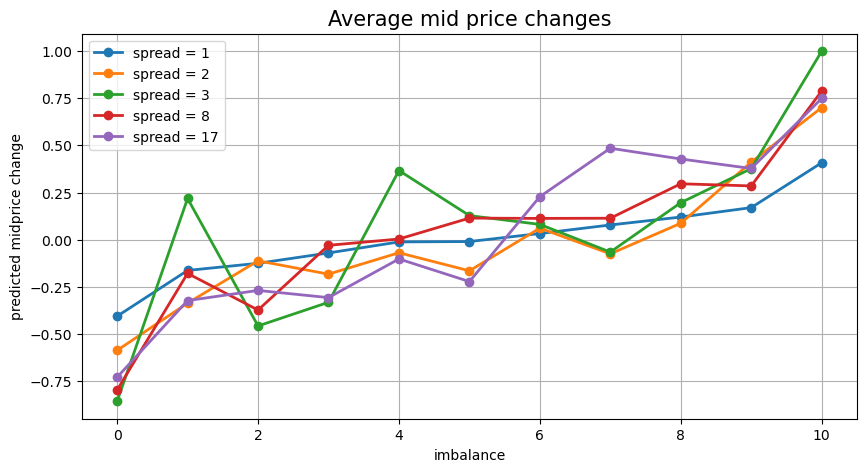

In [18]:
spread_encoder = SpreadEncoder(tick_size, max_quantile, max_steps, step_inc)
encoder = Encoder(n, spread_encoder)
micro_pricer = DummyMicroPrice(encoder)
micro_pricer.fit(imb, spread, dm)

plt.figure(figsize=(10, 5))
plt.title("Average mid price changes", fontsize=15)
for s in micro_pricer.encoder.spread_set[:]:
    plt.plot(micro_pricer.encoder.imb_set, micro_pricer.G[s], '-o', label=f'spread = {s}', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()

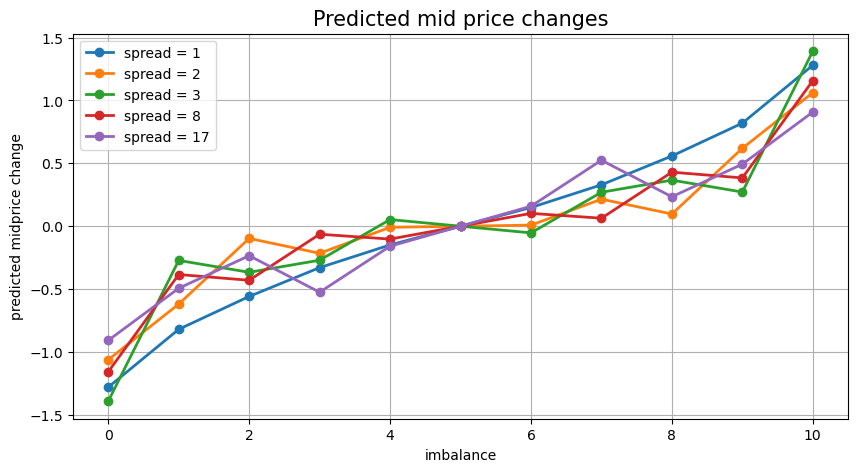

In [19]:
spread_encoder = SpreadEncoder(tick_size, max_quantile, max_steps, step_inc)
encoder = Encoder(n, spread_encoder)
micro_pricer = SimpleMicroPrice(encoder)
micro_pricer.fit(imb, spread, dm)

plt.figure(figsize=(10, 5))
plt.title("Predicted mid price changes", fontsize=15)
for s in micro_pricer.encoder.spread_set[:]:
    plt.plot(micro_pricer.encoder.imb_set, micro_pricer.G[s], '-o', label=f'spread = {s}', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()

## HTML plots

In [50]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

#model parameters:
#number of unique imbalances
n = 11
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1


spread_encoder = SpreadEncoder(tick_size, max_quantile, max_steps, step_inc)
encoder = Encoder(n, spread_encoder)

dummy_micro_pricer = DummyMicroPrice(encoder)
dummy_micro_pricer.fit(imb, spread, dm)
dummy_micro_price = mid_price + dummy_micro_pricer.predict(imb, spread)


micro_pricer = SimpleMicroPrice(encoder)
micro_pricer.fit(imb, spread, dm)
micro_price = mid_price + micro_pricer.predict(imb, spread)

In [21]:
idx = slice(None, 10000, 1)

In [22]:
dt = lobs.index

In [23]:
df_mid = pd.DataFrame( {"micro price":micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )

In [24]:
fig = px.line(df_mid)
fig.write_html("mid_micro_price_1_layer.html")

In [25]:
df_bidask = pd.DataFrame( {"micro price":micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )

In [26]:
fig = px.line(df_bidask)
fig.write_html("bid_ask_micro_price_1_layer.html")

In [27]:
df_mid = pd.DataFrame( {"micro price":dummy_micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )

fig = px.line(df_mid)
fig.write_html("mid_dummy_micro_price_1_layer.html")

df_bidask = pd.DataFrame( {"micro price":dummy_micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )

fig = px.line(df_bidask)
fig.write_html("bid_ask_dummy_micro_price_1_layer.html")

## 2 layers

In [40]:
n_layers = 2

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

In [29]:
#model parameters:
#number of unique imbalances
n = 11
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1

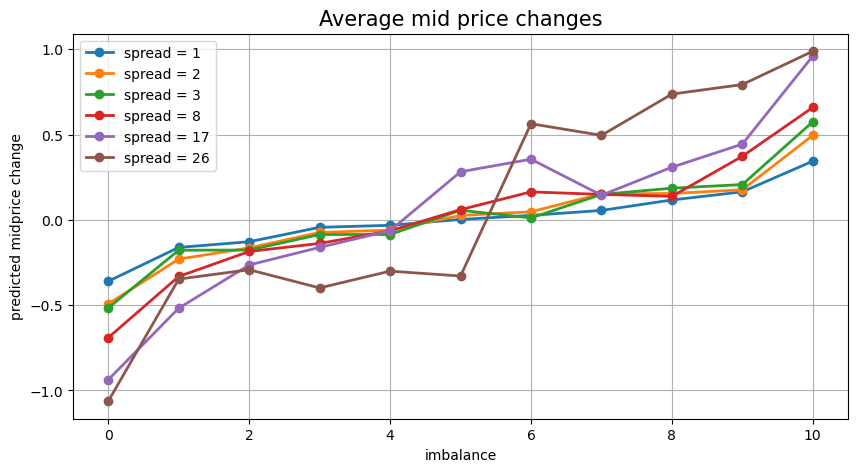

In [30]:
spread_encoder = SpreadEncoder(tick_size, max_quantile, max_steps, step_inc)
encoder = Encoder(n, spread_encoder)
micro_pricer = DummyMicroPrice(encoder)
micro_pricer.fit(imb, spread, dm)

plt.figure(figsize=(10, 5))
plt.title("Average mid price changes", fontsize=15)
for s in micro_pricer.encoder.spread_set[:]:
    plt.plot(micro_pricer.encoder.imb_set, micro_pricer.G[s], '-o', label=f'spread = {s}', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()

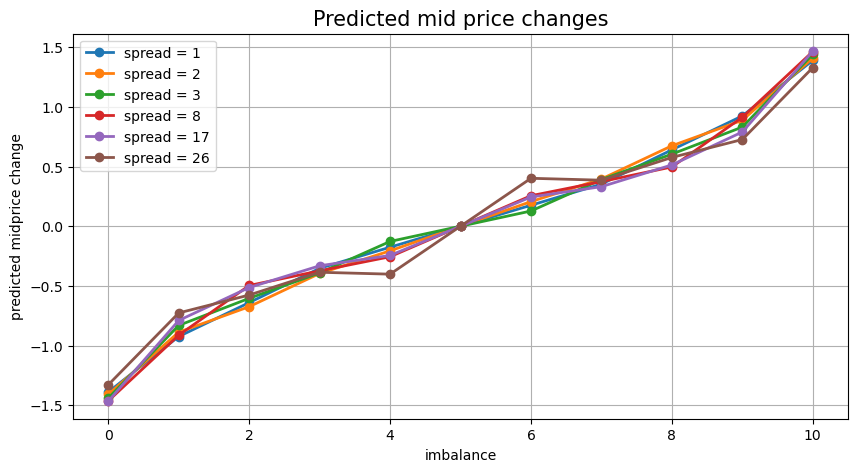

In [31]:
spread_encoder = SpreadEncoder(tick_size, max_quantile, max_steps, step_inc)
encoder = Encoder(n, spread_encoder)
micro_pricer = SimpleMicroPrice(encoder)
micro_pricer.fit(imb, spread, dm)

plt.figure(figsize=(10, 5))
plt.title("Predicted mid price changes", fontsize=15)
for s in micro_pricer.encoder.spread_set[:]:
    plt.plot(micro_pricer.encoder.imb_set, micro_pricer.G[s], '-o', label=f'spread = {s}', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()

## HTML plots

In [32]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

#model parameters:
#number of unique imbalances
n = 11
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1


spread_encoder = SpreadEncoder(tick_size, max_quantile, max_steps, step_inc)
encoder = Encoder(n, spread_encoder)

dummy_micro_pricer = DummyMicroPrice(encoder)
dummy_micro_pricer.fit(imb, spread, dm)
dummy_micro_price = mid_price + dummy_micro_pricer.predict(imb, spread)


micro_pricer = SimpleMicroPrice(encoder)
micro_pricer.fit(imb, spread, dm)
micro_price = mid_price + micro_pricer.predict(imb, spread)

In [43]:
encoder.fit(imb, spread, dm)
_, _, dm_encoded = encoder.predict(imb, spread, dm)

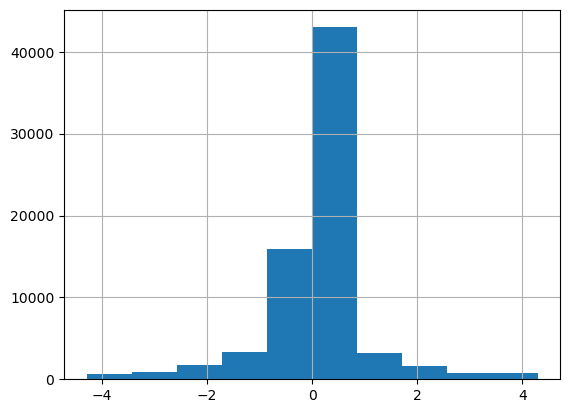

In [47]:
plt.hist(dm_encoded)
plt.grid()
plt.show()

In [33]:
idx = slice(None, 10000, 1)

In [34]:
dt = lobs.index

In [35]:
df_mid = pd.DataFrame( {"micro price":micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )

In [36]:
fig = px.line(df_mid)
fig.write_html("mid_micro_price_2_layer.html")

In [37]:
df_bidask = pd.DataFrame( {"micro price":micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )

In [38]:
fig = px.line(df_bidask)
fig.write_html("bid_ask_micro_price_2_layer.html")

In [39]:
df_mid = pd.DataFrame( {"micro price":dummy_micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )

fig = px.line(df_mid)
fig.write_html("mid_dummy_micro_price_2_layer.html")

df_bidask = pd.DataFrame( {"micro price":dummy_micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )

fig = px.line(df_bidask)
fig.write_html("bid_ask_dummy_micro_price_2_layer.html")